# FordGo Bike Analysis Between Subscribers and Customers
## by Alex Kim

## Investigation Overview

> Have you ever seen a rental bike on the street and asked yourself who uses that? Have you ever rented a bike that you found the street for a few minutes and wondered how many others were using the same?

>The overall goal of this presentation is to understand how customers and subscribers are using the FordGo bikes over time. I want to understand the how different age groups are using the FordGo bikes and how long they are using the bikes.

## Dataset Overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob as glob
import datetime

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
#creating the df for 2017 data
df_2017 = pd.read_csv('../data/2017-fordgobike-tripdata.csv')
#for all of the 2018 data files, I used the for loop below to combine and concatenate all files into one dataframe.
path = '../data/2018'
allFiles = glob.glob(path + "/*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

df_2018 = pd.concat(list_, axis = 0, ignore_index = True)
#merge the 2017 dataset with the combined 2018 dataset
df = df_2017.append(df_2018, ignore_index=True)

#convert all of the data to their correct types
df.end_time = pd.to_datetime(df.end_time)
df.start_time = pd.to_datetime(df.start_time)
df.member_gender = df.member_gender.astype('category')
df.user_type = df.user_type.astype('category')
pd.set_option('precision', 0)

In [3]:
#create an age variable in the dataframe
df['age'] = 2019-df.member_birth_year
#create bings for age groups
df['member_age_bins'] = df['age'].apply(lambda x: '10 - 17' if 10<x<=17
                                        else '18 - 25' if 18<x<=26
                                        else '26 - 35' if 26<x<=36
                                        else '36 - 49' if 36<x<=49
                                        else '50 >' if x>=50
                                        else x)

#get the date from start time
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date
#get the start time month and year
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))

#calculate duration in minutes
df['duration_min']=df['duration_sec']/60

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Count of Riders per Age Group

> The majority of rides are taken by people between the ages of 26-35 followed by people aged 36-49. The 18-25 group was almost as low as people over the age of 50.

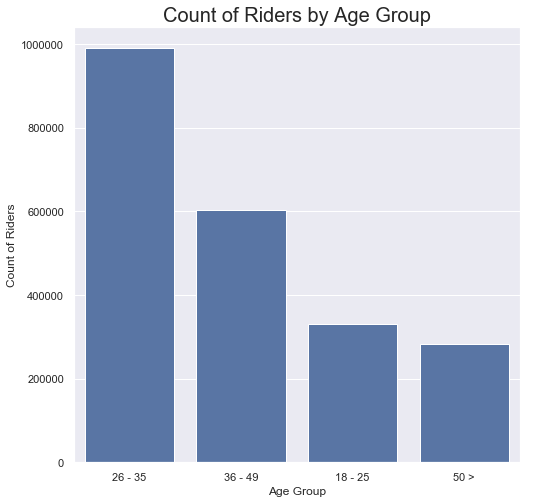

In [6]:
#used a subset of the data for people under 90 years of age
age_counts = df.query('age<=90').age.value_counts()
#increased the figure size
sb.set(rc={'figure.figsize':(8,8)})
#create the plot
base = sb.color_palette()[0]
sb.countplot(data=df, x='member_age_bins', color=base, order = df['member_age_bins'].value_counts().index)
#create the axis labels
plt.xlabel('Age Group');
plt.ylabel('Count of Riders');
plt.title('Count of Riders by Age Group',fontsize=20);

## Proportion of Riders by Age

> Almost 6% of all riders were 31 years old. 30 and 32 year olds followed right behind as the second and third highest usage age.

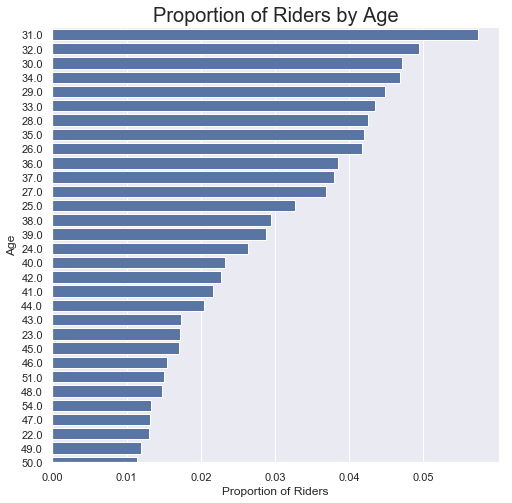

In [7]:
#converting the counts into proportions
n_age = df.age.notna().sum()
max_age_counts = age_counts.max()
max_prop = max_age_counts/n_age
#create new tick marks
tick_props=np.arange(0, max_prop, 0.01)
tick_names=['{:0.02f}'.format(v) for v in tick_props]
plt.xticks(tick_props * n_age, tick_names)
type_order = age_counts.index
#create the plot
sb.countplot(data=df, y='age', order=type_order,color=base)
#create the axis labels
plt.xlabel('Proportion of Riders');
plt.ylabel('Age');
plt.ylim(30)
plt.title('Proportion of Riders by Age',fontsize=20);

## Average Duration in Minutes based on User Type

> Customers are taking longer rides on average than subscribers. The average customer ride is around 30 minutes!

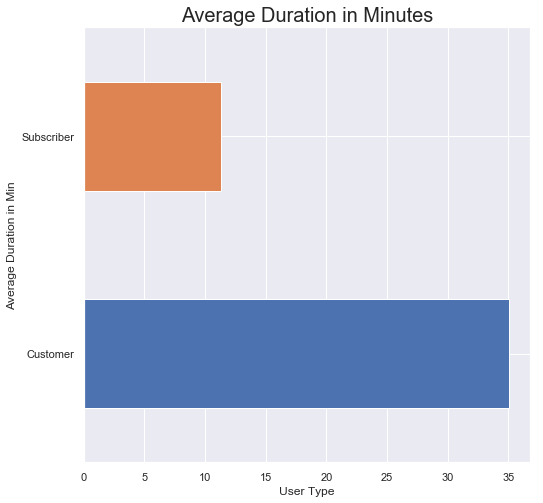

In [10]:
#plot the duration based on ride_month
df.groupby('user_type')['duration_min'].mean().plot(kind='barh')
#create the axis labels
plt.xlabel('User Type');
plt.ylabel('Average Duration in Min');
plt.title('Average Duration in Minutes',fontsize=20);

## Count of Riders by Month

> The count of riders for subscribers has grown in 2018. The subscribers have grown exponentially within one year. The count of customers has stayed relatively the same over the past year.

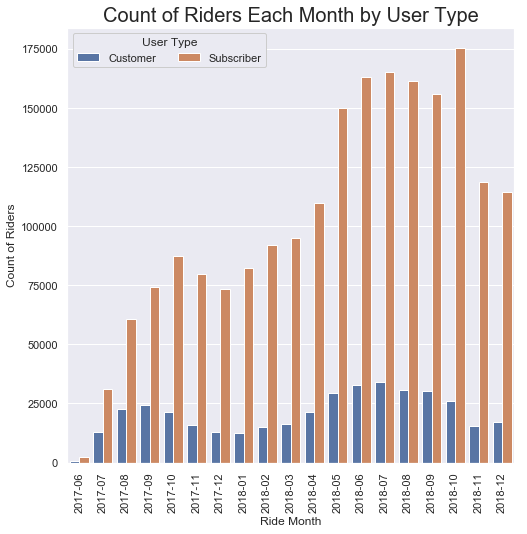

In [11]:
#create a histogram based on ride month and user type
sb.countplot(data = df.sort_values(by=['start_time_year_month']), x = 'start_time_year_month', hue = 'user_type')
#create the legend
plt.legend(loc = 2, ncol = 2, framealpha = 1, title = 'User Type')
#create the axis labels
plt.xlabel('Ride Month');
plt.ylabel('Count of Riders');
plt.title('Count of Riders Each Month by User Type',fontsize=20);
plt.xticks(rotation=90);

## Rides per Month by Age Group

> The number of riders between 26-35 has been growing exponentially month over month. Surprisingly, people over 50 years old were taking more rides than 18-25 year olds in 2017.

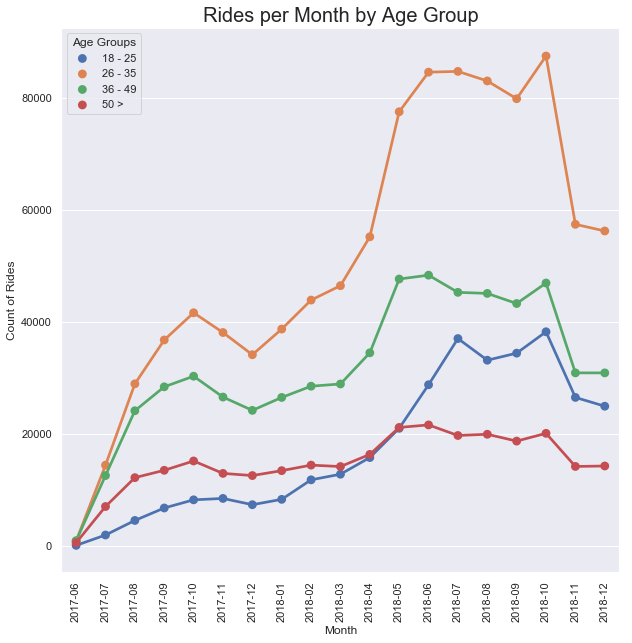

In [12]:
#create a new dataframe grouped by month and member age bins then get the aggregate of bike rides
df_age = df.groupby(['start_time_year_month', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()
#change the figure size
plt.figure(figsize=(10,10))
#plot the graph
sb.pointplot(x='start_time_year_month', y='bike_id', hue='member_age_bins',  data=df_age.sort_values(by=['start_time_year_month']))
#create title and labels
plt.title('Rides per Month by Age Group', fontsize=20)
plt.xlabel('Month');
plt.legend(title='Age Groups')
plt.ylabel('Count of Rides');
plt.xticks(rotation=90);

## Duration of Rides by Age Group Over Time

> During April to August of 2018, 18-25 year olds were taking the longest rides. Probably due to colleges being in session at those times. Surprisingly, people over the age of 50 had the second highest duration of rides during this time.

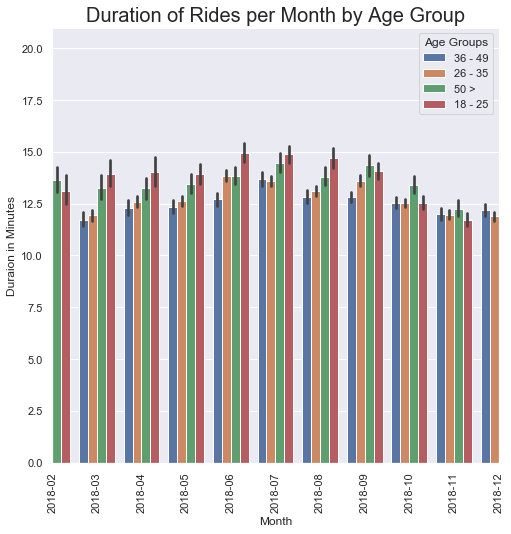

In [14]:
#create a subset of the data
df_subset = df.query('duration_sec < 40000')
#plot the barchart for month, duration, and member age groups
sb.barplot(data=df.sort_values(by=['start_time_year_month']),
           x='start_time_year_month', 
           y='duration_min',
           hue='member_age_bins')
#limit to last 10 months and only 20 minute durations
plt.xlim(8,18);
plt.ylim(0,21);
#create title and labels
plt.title('Duration of Rides by Age Group Over Time', fontsize=20)
plt.xlabel('Month');
plt.legend(title='Age Groups')
plt.ylabel('Duraion in Minutes');
plt.xticks(rotation=90);

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!